In [17]:
import shutil
import urllib.request as request
from contextlib3 import closing
import zipfile38 as zipfile
import os
import pandas as pd
import glob
from wetterdienst import Wetterdienst
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# install packages.
# uncomment if package is missing...
# comment this out when everything has been installed ;)
# hint: you can address your console from a notebook using %

#%pip install wetterdienst
#%pip install pandas
#%pip install seaborn
#%pip install contextlib2
#%pip install contextlib3
#%pip install zipfile38
# ...

In [19]:
# only apply changes here....

# Whats your location...

latitude = 49.34528
longitude = 9.97944


In [20]:
# some variables... those hopefully dont change very often ;)

# url of the ftp server
# xxxx is replaced by numbers defined in vals
url="""ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_Dxxxx.csv.zip"""
vals = [5,10,20,30,45,60,90,120,180,240,360,540,720,1080,1440,2880,4320]
# length of number includin pre-zeros
# example: 
# val = 5
# vallen = 5
# then xxxx is replaced wit 00005
vallen = 4

# name of vals in dataframe
valname = "precipitation_time / min"
# path where the FTP-server downloads are copied to
datapath = "data"
# index/column-name of weather station in files from FTP
index = "INDEX_RC"

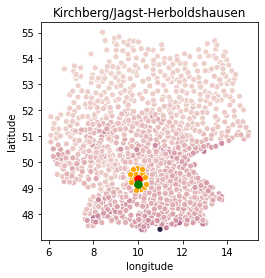

In [21]:
def get_ftp(url,path="",rm=True):
    if path:
        file = "/".join( (path,url.split("/")[-1] ) )
    else:
        file=url.split("/")[-1]
    try:
        with closing(request.urlopen(url)) as r:
            with open(file, 'wb') as f:
                shutil.copyfileobj(r, f)
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(path)
        if rm:
            os.system( "rm "+file )
        return file.replace(".zip","")
    except:
        return None

    
def get_stations(latitude,longitude,path="",distance=50):
    API = Wetterdienst("dwd", "observation")
    stations = API(
        parameter=["precipitation_height"],
        resolution="minute_1",)#.filter_by_station_id(station_id=list(range(10000) ) )
    df = stations.filter_by_station_id(station_id=list(range(10000) ) ).df

    yi = "latitude"
    xi = "longitude"
    zi = "height"

    points = sns.scatterplot(data=df, x=xi, y=yi, hue=zi, )

    ratio = ( df[xi].max()-df[xi].min() )/(df[yi].max()-df[yi].min() )    

    #s = (49.34528, 9.97944)
    df = stations.filter_by_distance(latitude=latitude,longitude=longitude,distance=distance,unit="km").df
    
    sea = sns.scatterplot(data=df, x=xi, y=yi, color="orange") 

    plt.plot(longitude,latitude,".r",markersize=15)  
    plt.plot(df[xi][0],df[yi][0],".",color="green",markersize=15)   
      

    grid_id = df["station_id"][0]
    name = df["name"][0]
    #dist = df["name"][0]
    if path:    
        path = "/".join( (path,str(grid_id) ) )
    else:
        path = str(grid_id) 
    
    plt.xlabel(xi)
    plt.ylabel(yi)
    plt.gca().set_aspect(ratio)
    plt.legend([],[], frameon=False)
    #plt.title("next station:\n"+name)
    plt.title(name)
    #plt.gca().set_aspect('equal')#, adjustable='box')
    plt.savefig(path+"_stations.png")
    plt.savefig(path+"_stations.pdf")
    plt.show()
    plt.close()

    for key in df:
        if "date" in key:
            df[key] = df[key].astype(str).str[:-6]
    
    #df.to_csv('stations_1.csv')
    df.to_excel(path+'_stations.xlsx')
    df.head()
    
    return grid_id
    
    
# get your station
grid_id = get_stations(latitude,longitude)

In [23]:
# get FTP data
try:
    os.mkdir(datapath)
except:
    None

# kinda hard code :/
files = []
for i in vals:
    i = str(i)
    x = ( vallen-len(i) )*"0" + i
    xx = url.replace("xxxx",x)
    path = get_ftp( xx, path=datapath )
    print(xx)
    files.append(path)

ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_D0005.csv.zip
ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_D0010.csv.zip
ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_D0020.csv.zip
ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_D0030.csv.zip
ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_D0045.csv.zip
ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_periods/precipitation/KOSTRA/KOSTRA_DWD_2010R/asc/StatRR_KOSTRA-DWD-2010R_D0060.csv.zip
ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/return_per

In [10]:
# build what you need...

# for stabillity reasons:
# ...but hard code :/
files = sorted(glob.glob(datapath+"/*.csv"))
vals  = [ f.split(".")[-2].split("D")[-1] for f in files ]

collection_mm = []
collection_lsha = []
valnos = []
for val,file in zip(vals,files):
    df = pd.read_csv(file,delimiter=";").set_index(index)
    goal   = df.iloc[int(grid_id)]
    collection_mm.append( goal )
    valno = int( ''.join(x for x in val if x.isdigit()) ) 
    collection_lsha.append( goal*10000/60/valno )
    valnos.append(valno)

columns={}
for col in df.columns:
    columns[col] = int( ''.join(x for x in col if x.isdigit()) ) 
               
df_mm = pd.DataFrame(collection_mm, columns=df.columns)    
df_mm = df_mm.rename(columns=columns)
df_mm[valname] = valnos
df_mm = df_mm.set_index(valname)
#result = pd.concat( collection )

df_mm.to_excel(grid_id+"_data_mm.xlsx")

df_lsha = pd.DataFrame(collection_lsha, columns=df.columns)    
df_lsha = df_lsha.rename(columns=columns)
df_lsha[valname] = valnos
df_lsha = df_lsha.set_index(valname)

df_lsha.to_excel(grid_id+"_data_lsha.xlsx")
df_lsha

,1,2,3,5,10,20,30,50,100
precipitation_time / min,,,,,,,,,
5,163.333333,210.000000,236.666667,270.000000,316.666667,366.666667,393.333333,426.666667,473.333333
10,126.666667,160.000000,178.333333,203.333333,235.000000,268.333333,286.666667,311.666667,343.333333
20,88.333333,111.666667,124.166667,140.833333,163.333333,185.833333,199.166667,215.833333,238.333333
30,68.333333,86.111111,97.222222,110.555556,128.333333,146.666667,157.222222,170.555556,188.888889
45,50.740741,65.185185,73.703704,84.444444,99.259259,113.703704,122.222222,133.333333,147.777778
60,40.277778,52.777778,60.277778,69.444444,81.944444,94.444444,101.944444,111.111111,123.611111
90,29.259259,37.962963,43.148148,49.444444,58.148148,66.851852,72.037037,78.518519,87.222222
120,23.333333,30.000000,34.027778,38.888889,45.694444,52.361111,56.388889,61.250000,68.055556
180,16.944444,21.574074,24.351852,27.777778,32.500000,37.129630,39.907407,43.333333,48.055556


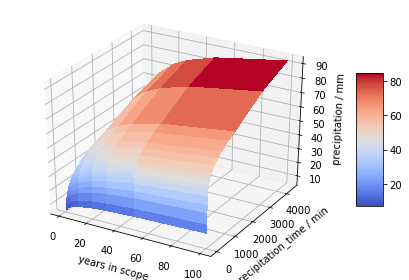

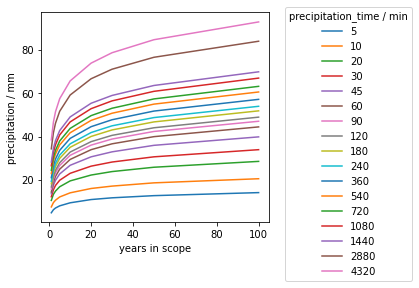

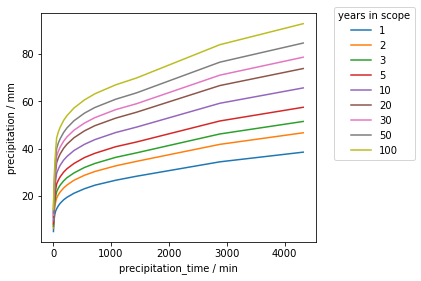

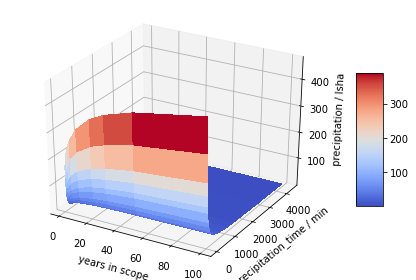

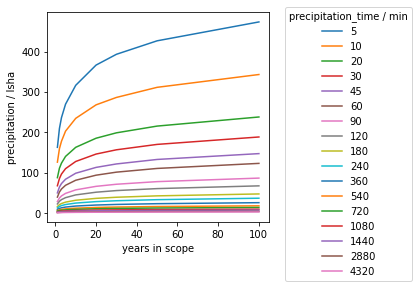

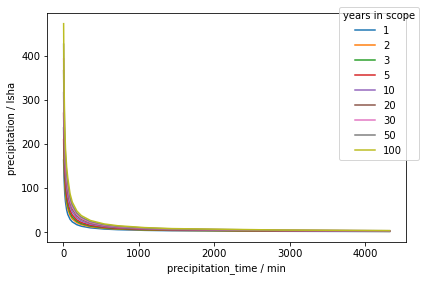

In [25]:
def plot_output(df,path,valname,unit):
    
    Z = df.to_numpy()
    #x = [ int(''.join(x for x in r if x.isdigit()) ) for r in df.columns ]
    #x = [ r for r in df.columns]
    x = list(df.columns)
    #y = [ int(''.join(x for x in r if x.isdigit()) ) for r in df.index ]
    y = df.index
    X, Y = np.meshgrid(np.arange(len(x)), np.arange(len(y)))
    X, Y = np.meshgrid(x,y)

    from matplotlib import cm

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Add a color bar which maps values to colors.
    fig.set_tight_layout(True),
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_ylabel(valname)
    ax.set_xlabel("years in scope")
    ax.set_zlabel("precipitation / "+unit)

    plt.tight_layout()
    #plt.savefig(path+"_surf.png")
    #plt.savefig(path+"_surf.pdf")
    plt.show()
    plt.close()

    for index, row in df.iterrows():
        plt.plot(x,row,label = index)
        #df.iloc[int(grid_id)]

    plt.xlabel("years in scope")
    plt.ylabel("precipitation / "+unit)
    plt.legend(title=valname,bbox_to_anchor = (1.05, 1.05))   
    plt.tight_layout()
    plt.savefig(path+"_years.png")
    plt.savefig(path+"_years.pdf")
    plt.show()
    plt.close()


    for i in df.columns:
        plt.plot(y,df[i],label = i)
        #df.iloc[int(grid_id)]

    plt.ylabel("precipitation / "+unit)
    plt.xlabel(valname)
    plt.legend(title="years in scope",bbox_to_anchor = (1.05, 1.05))    
    plt.tight_layout()
    plt.savefig(path+"_val.png")
    plt.savefig(path+"_val.pdf")
    plt.show()
    plt.close()
    
    return
    

    
plot_output(df_mm ,str(grid_id)+"_mm",valname,"mm")
plot_output(df_lsha ,str(grid_id)+"_lsha",valname,"lsha")
    

In [26]:
# start your own calculations here :)
# you should be able to use pandas and python...
# ...then youll achieve your goals :)